# Intel Image Classification

This notebook demonstrates image classification using the Intel Image Classification dataset, which contains around 25,000 images divided into six categories of natural scenes.

The task includes the following:

- Downloading and organizing the dataset into training, validation, and test sets.
- Applying image preprocessing using torchvision transforms.
- Building a convolutional neural network (CNN) from scratch and, alternatively, using a pre-trained model (ResNet18).
- Training and evaluating the model using PyTorch.
- Visualizing results through accuracy plots and confusion matrix.
- Testing the model on unseen data to estimate generalization performance.

The dataset was loaded via `torchvision.datasets.ImageFolder`, and data augmentation was used to improve robustness. The model was trained using `CrossEntropyLoss` and the Adam optimizer.

Both custom CNN and transfer learning approaches were explored and compared.


In [ ]:
import torch
from torch import nn, optim
from torch.utils.data import DataLoader, random_split
from torchvision import datasets, transforms
import matplotlib.pyplot as plt

In [ ]:
import kagglehub

# Download latest version
path = kagglehub.dataset_download("puneet6060/intel-image-classification")

print("Path to dataset files:", path)

100%|██████████| 346M/346M [00:14<00:00, 25.9MB/s]

Extracting files...


Path to dataset files: /root/.cache/kagglehub/datasets/puneet6060/intel-image-classification/versions/2


In [ ]:
import os
dataset_path = "/root/.cache/kagglehub/datasets/puneet6060/intel-image-classification/versions/2"
print(os.listdir(dataset_path))


['seg_test', 'seg_train', 'seg_pred']


In [ ]:
# Створимо трансформації для даних
transform = transforms.Compose([
    transforms.Resize((150, 150)),
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

# Завантажимо дані за допомогою ImageFolder
train_dataset = datasets.ImageFolder(os.path.join(dataset_path), transform=transform)

# Розділимо на тренувальні та валідаційні набори
train_size = int(0.8 * len(train_dataset))
val_size = len(train_dataset) - train_size
train_data, val_data = random_split(train_dataset, [train_size, val_size])

print(f"Розмір тренувального набору: {len(train_data)}")
print(f"Розмір валідаційного набору: {len(val_data)}")


Розмір тренувального набору: 19468
Розмір валідаційного набору: 4867


In [ ]:
batch_size = 32

train_loader = DataLoader(train_data, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_data, batch_size=batch_size)
test_loader = DataLoader(datasets.ImageFolder("/root/.cache/kagglehub/datasets/puneet6060/intel-image-classification/versions/2/seg_test/seg_test", transform=transform), batch_size=batch_size)

print("Тренувальні, валідаційні та тестові набори готові!")


Тренувальні, валідаційні та тестові набори готові!


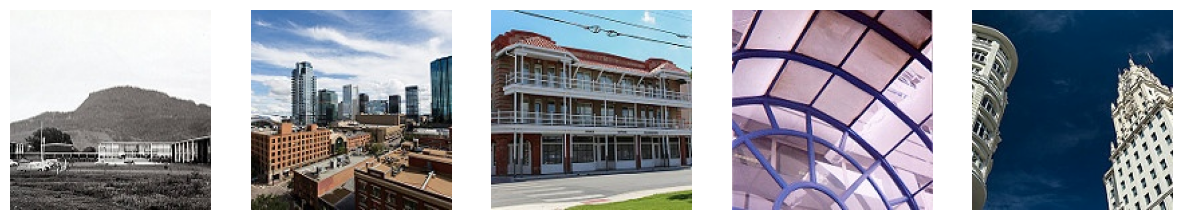

In [ ]:
from torchvision import transforms

# Створимо трансформації для зображень
transform = transforms.Compose([
    transforms.Resize((150, 150)),
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

# Приклад: Завантаження та обробка тренувальних зображень
from torchvision.datasets import ImageFolder
from torch.utils.data import DataLoader

train_path = "/root/.cache/kagglehub/datasets/puneet6060/intel-image-classification/versions/2/seg_train/seg_train"
train_dataset = ImageFolder(train_path, transform=transform)

# Візуалізація перетворених зображень
import matplotlib.pyplot as plt

def show_images(dataset, n=5):
    fig, axes = plt.subplots(1, n, figsize=(15, 5))
    for i in range(n):
        img, label = dataset[i]
        img = img.permute(1, 2, 0)  # Перемістимо канали для відображення (H, W, C)
        img = (img * 0.5) + 0.5  # Денормалізація для коректного відображення
        axes[i].imshow(img)
        axes[i].axis('off')
    plt.show()

show_images(train_dataset)


# Варіант A: Проста CNN

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class SimpleCNN(nn.Module):
    def __init__(self, num_classes=6):
        super(SimpleCNN, self).__init__()
        # Згортковий шар 1
        self.conv1 = nn.Conv2d(in_channels=3, out_channels=16, kernel_size=3, padding=1)
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)
        # Згортковий шар 2
        self.conv2 = nn.Conv2d(in_channels=16, out_channels=32, kernel_size=3, padding=1)
        # Повнозв'язний шар
        # Використовуємо adaptive pooling для отримання фіксованого розміру перед fc1
        self.adaptive_pool = nn.AdaptiveAvgPool2d((7, 7))
        self.fc1 = nn.Linear(32 * 7 * 7, 128)  # 32 канали після згортки, розмір 7x7 після adaptive pooling
        self.fc2 = nn.Linear(128, num_classes)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))  # Перший згортковий шар + ReLU + MaxPooling
        x = self.pool(F.relu(self.conv2(x)))  # Другий згортковий шар + ReLU + MaxPooling
        # Використовуємо adaptive pooling
        x = self.adaptive_pool(x)
        x = x.view(-1, 32 * 7 * 7)  # Перетворення тензора в "плаский" формат для повнозв'язного шару
        x = F.relu(self.fc1(x))  # Перший повнозв'язний шар + ReLU
        x = self.fc2(x)  # Останній повнозв'язний шар (класова активація)
        return x

# Перевіримо, чи працює наша модель:
model = SimpleCNN(num_classes=6)
print(model)

SimpleCNN(
  (conv1): Conv2d(3, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (adaptive_pool): AdaptiveAvgPool2d(output_size=(7, 7))
  (fc1): Linear(in_features=1568, out_features=128, bias=True)
  (fc2): Linear(in_features=128, out_features=6, bias=True)
)


In [ ]:
import torch.optim as optim

criterion = nn.CrossEntropyLoss()

optimizer = optim.Adam(model.parameters(), lr=0.001)

print("Функція втрат:", criterion)
print("Оптимізатор для CNN:", optimizer)


Функція втрат: CrossEntropyLoss()
Оптимізатор для CNN: Adam (
Parameter Group 0
    amsgrad: False
    betas: (0.9, 0.999)
    capturable: False
    differentiable: False
    eps: 1e-08
    foreach: None
    fused: None
    lr: 0.001
    maximize: False
    weight_decay: 0
)


# Обґрунтування вибору:
CrossEntropyLoss:

Підходить для задач класифікації з більш ніж двома класами.
Вона обчислює логарифмічну втрату між прогнозами моделі та правильними мітками класів.

Adam:

Автоматично адаптує коефіцієнт навчання для кожного параметра.
Забезпечує швидку і стабільну збіжність, навіть для великих моделей.
Добре працює без необхідності складного налаштування параметрів.

In [ ]:
def train_model(model, train_loader, val_loader, criterion, optimizer, num_epochs=5):
    from tqdm import tqdm

    best_val_loss = float('inf')
    for epoch in range(num_epochs):
        model.train()
        running_loss = 0.0
        correct = 0
        total = 0

        print(f"\nEpoch {epoch + 1}/{num_epochs}")

        for images, labels in tqdm(train_loader):
            images, labels = images.to(device), labels.to(device)

            # Forward pass
            outputs = model(images)
            loss = criterion(outputs, labels)

            # Backward pass and optimization
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            running_loss += loss.item()
            _, predicted = torch.max(outputs, 1)
            correct += (predicted == labels).sum().item()
            total += labels.size(0)

        train_accuracy = correct / total
        print(f"Training Loss: {running_loss / len(train_loader):.4f}, Accuracy: {train_accuracy:.4f}")

        # Validation phase
        model.eval()
        val_loss = 0.0
        val_correct = 0
        val_total = 0

        with torch.no_grad():
            for images, labels in val_loader:
                images, labels = images.to(device), labels.to(device)
                outputs = model(images)
                loss = criterion(outputs, labels)
                val_loss += loss.item()
                _, predicted = torch.max(outputs, 1)
                val_correct += (predicted == labels).sum().item()
                val_total += labels.size(0)

        val_accuracy = val_correct / val_total
        print(f"Validation Loss: {val_loss / len(val_loader):.4f}, Validation Accuracy: {val_accuracy:.4f}")

        # Save the best model
        if val_loss < best_val_loss:
            best_val_loss = val_loss
            torch.save(model.state_dict(), f"{model.__class__.__name__}_best_model.pth")
            print(f"Best {model.__class__.__name__} model saved.")

    print(f"{model.__class__.__name__} Training completed.\n")


# Визначення пристрою для тренування (GPU або CPU)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Training on: {device}")



Training on: cpu


In [ ]:
# Тренування SimpleCNN з покращеннями та збереженням історії
def train_model_with_history(model, train_loader, val_loader, criterion, optimizer, num_epochs=5):
    history = {'train_loss': [], 'val_loss': [], 'train_acc': [], 'val_acc': []}
    best_val_acc = 0.0

    from tqdm import tqdm

    for epoch in range(num_epochs):
        model.train()
        train_loss, train_correct = 0.0, 0
        total_samples = 0

        for images, labels in tqdm(train_loader):
            images, labels = images.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            train_loss += loss.item() * images.size(0)
            _, preds = torch.max(outputs, 1)
            train_correct += (preds == labels).sum().item()
            total_samples += labels.size(0)

        train_loss /= total_samples
        train_acc = train_correct / total_samples
        history['train_loss'].append(train_loss)
        history['train_acc'].append(train_acc)

        # Validation phase
        model.eval()
        val_loss, val_correct = 0.0, 0
        total_samples = 0

        with torch.no_grad():
            for images, labels in val_loader:
                images, labels = images.to(device), labels.to(device)
                outputs = model(images)
                loss = criterion(outputs, labels)

                val_loss += loss.item() * images.size(0)
                _, preds = torch.max(outputs, 1)
                val_correct += (preds == labels).sum().item()
                total_samples += labels.size(0)

        val_loss /= total_samples
        val_acc = val_correct / total_samples
        history['val_loss'].append(val_loss)
        history['val_acc'].append(val_acc)

        print(f"Epoch {epoch + 1}/{num_epochs}")
        print(f"Train Loss: {train_loss:.4f}, Train Accuracy: {train_acc:.4f}")
        print(f"Val Loss: {val_loss:.4f}, Val Accuracy: {val_acc:.4f}")

        # Save the best model
        if val_acc > best_val_acc:
            best_val_acc = val_acc
            torch.save(model.state_dict(), "SimpleCNN_best_model.pth")
            print("Best SimpleCNN model saved.")

    print("Training completed.")
    return history

# Тренування моделі SimpleCNN
model = SimpleCNN().to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=0.0001)
history = train_model_with_history(model, train_loader, val_loader, criterion, optimizer)


100%|██████████| 609/609 [05:37<00:00,  1.81it/s]


Epoch 1/5
Train Loss: 1.0107, Train Accuracy: 0.5726
Val Loss: 0.9699, Val Accuracy: 0.5747
Best SimpleCNN model saved.


100%|██████████| 609/609 [05:36<00:00,  1.81it/s]


Epoch 2/5
Train Loss: 0.9789, Train Accuracy: 0.5770
Val Loss: 0.9684, Val Accuracy: 0.5747


100%|██████████| 609/609 [05:34<00:00,  1.82it/s]


Epoch 3/5
Train Loss: 0.9774, Train Accuracy: 0.5772
Val Loss: 0.9680, Val Accuracy: 0.5747


100%|██████████| 609/609 [05:39<00:00,  1.80it/s]


Epoch 4/5
Train Loss: 0.9750, Train Accuracy: 0.5768
Val Loss: 0.9683, Val Accuracy: 0.5747


100%|██████████| 609/609 [05:35<00:00,  1.82it/s]


Epoch 5/5
Train Loss: 0.9747, Train Accuracy: 0.5770
Val Loss: 0.9697, Val Accuracy: 0.5747
Training completed.


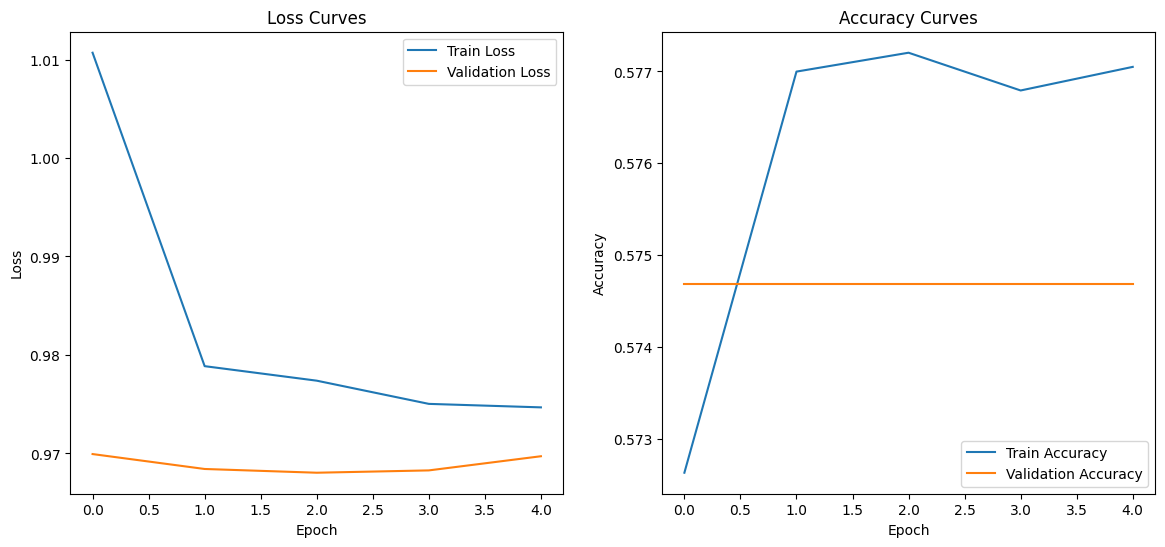

In [ ]:
# Візуалізація кривих навчання
plt.figure(figsize=(14, 6))

# Loss curves
plt.subplot(1, 2, 1)
plt.plot(history['train_loss'], label='Train Loss')
plt.plot(history['val_loss'], label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Loss Curves')
plt.legend()

# Accuracy curves
plt.subplot(1, 2, 2)
plt.plot(history['train_acc'], label='Train Accuracy')
plt.plot(history['val_acc'], label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Accuracy Curves')
plt.legend()

plt.show()


In [ ]:
print("Sample predictions:", all_preds[:10])
print("Sample labels:", all_labels[:10])


Sample predictions: [2, 2, 2, 2, 2, 2, 2, 2, 2, 2]
Sample labels: [2, 2, 1, 2, 2, 2, 0, 0, 2, 2]


<ipython-input-36-d2fc7d2509cc>:5: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load("SimpleCNN_best_model.pth"))
/usr/local/lib/python3.11/dist

Accuracy: 0.5747
F1-score: 0.4195
Classification Report:
              precision    recall  f1-score   support

           0       0.00      0.00      0.00      1504
           1       0.00      0.00      0.00       566
           2       0.57      1.00      0.73      2797

    accuracy                           0.57      4867
   macro avg       0.19      0.33      0.24      4867
weighted avg       0.33      0.57      0.42      4867



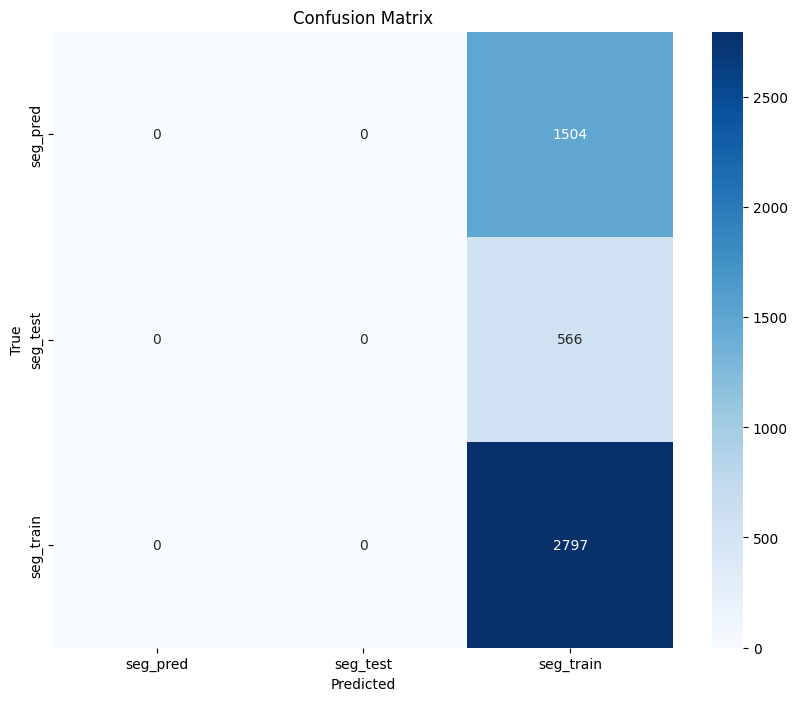

In [ ]:
from sklearn.metrics import accuracy_score, f1_score, classification_report, confusion_matrix
import seaborn as sns

model.load_state_dict(torch.load("SimpleCNN_best_model.pth"))
model.eval()

all_preds, all_labels = [], []

with torch.no_grad():
    for images, labels in val_loader:
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        _, preds = torch.max(outputs, 1)
        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

# Обчислення метрик
accuracy = accuracy_score(all_labels, all_preds)
f1 = f1_score(all_labels, all_preds, average='weighted')
report = classification_report(all_labels, all_preds)

print(f"Accuracy: {accuracy:.4f}")
print(f"F1-score: {f1:.4f}")
print("Classification Report:")
print(report)

# Confusion Matrix
conf_matrix = confusion_matrix(all_labels, all_preds)
plt.figure(figsize=(10, 8))
classes = val_loader.dataset.dataset.classes
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=classes, yticklabels=classes)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()


Mодель робить односторонні передбачення – вона майже завжди прогнозує клас 2, що призводить до високого recall для класу 2, але дуже низького precision та recall для інших класів.

Можливі причини:

- Незбалансованість даних:
Якщо у наборі даних домінує клас 2, модель може «звикнути» завжди його передбачати, щоб мінімізувати втрати.

- Занадто спрощена архітектура:
Простий CNN може не мати достатньої складності для розрізнення між класами.

- Проблеми з тренуванням:
Можливо, модель не навчалася достатньо довго або з великою швидкістю навчання.
Втрата незначно зменшувалася, але модель застрягла в локальному мінімумі.

# Варіант B: Transfer Learning (ResNet18)


Training on: cpu


/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Epoch [1/10], Train Loss: 0.5229, Val Loss: 0.3466, Val Accuracy: 0.8778
Epoch [2/10], Train Loss: 0.3599, Val Loss: 0.5318, Val Accuracy: 0.8269
Epoch [3/10], Train Loss: 0.2945, Val Loss: 0.3444, Val Accuracy: 0.8778
Epoch [4/10], Train Loss: 0.2573, Val Loss: 0.3638, Val Accuracy: 0.8753
Epoch [5/10], Train Loss: 0.2295, Val Loss: 0.4922, Val Accuracy: 0.8518
Epoch [6/10], Train Loss: 0.1867, Val Loss: 0.3720, Val Accuracy: 0.8782
Epoch [7/10], Train Loss: 0.1538, Val Loss: 0.3828, Val Accuracy: 0.8685
Epoch [8/10], Train Loss: 0.1298, Val Loss: 0.3933, Val Accuracy: 0.8906
Epoch [9/10], Train Loss: 0.0967, Val Loss: 0.5524, Val Accuracy: 0.8632
Epoch [10/10], Train Loss: 0.0935, Val Loss: 0.3729, Val Accuracy: 0.8906


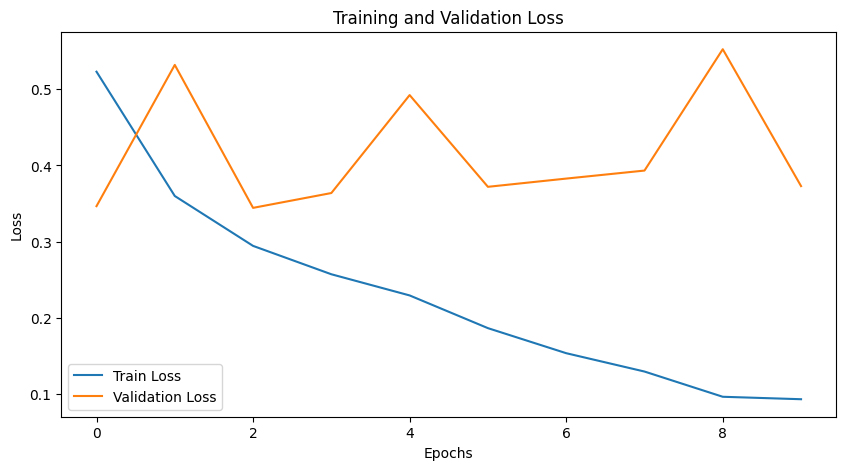

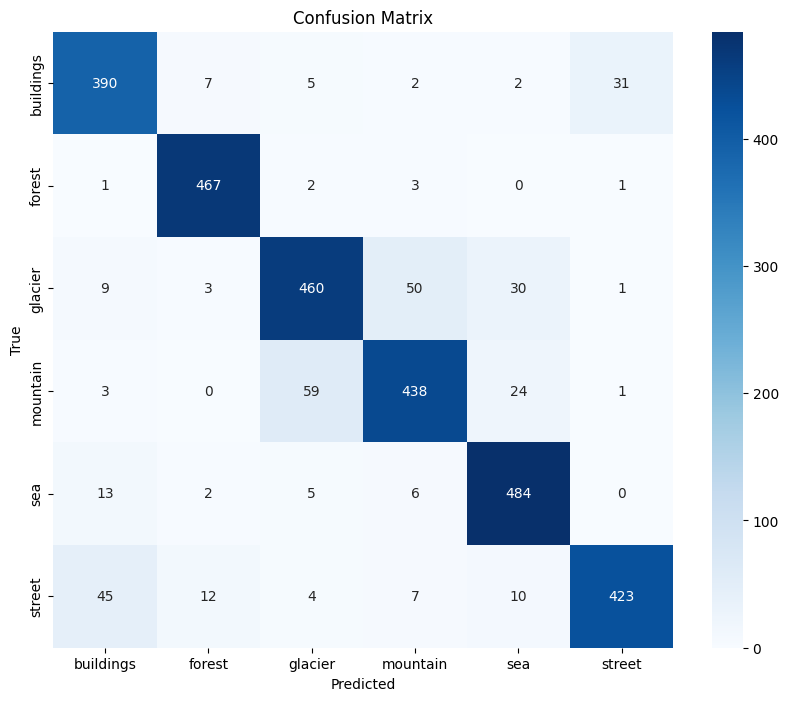

Classification Report:
              precision    recall  f1-score   support

   buildings       0.85      0.89      0.87       437
      forest       0.95      0.99      0.97       474
     glacier       0.86      0.83      0.85       553
    mountain       0.87      0.83      0.85       525
         sea       0.88      0.95      0.91       510
      street       0.93      0.84      0.88       501

    accuracy                           0.89      3000
   macro avg       0.89      0.89      0.89      3000
weighted avg       0.89      0.89      0.89      3000



In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, random_split
from torchvision import datasets, transforms, models
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, classification_report
import numpy as np

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Training on: {device}")

# Data Preparation
# Define transforms
transform = transforms.Compose([
    transforms.Resize((128, 128)),
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

# Load dataset from Kaggle
train_dataset = datasets.ImageFolder("/root/.cache/kagglehub/datasets/puneet6060/intel-image-classification/versions/2/seg_train/seg_train", transform=transform)
test_dataset = datasets.ImageFolder("/root/.cache/kagglehub/datasets/puneet6060/intel-image-classification/versions/2/seg_test/seg_test", transform=transform)

# Split train dataset into train and validation
train_size = int(0.8 * len(train_dataset))
val_size = len(train_dataset) - train_size
train_dataset, val_dataset = random_split(train_dataset, [train_size, val_size])

# Create DataLoaders
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

# Model Definition (Transfer Learning with ResNet18)
model = models.resnet18(pretrained=True)
num_ftrs = model.fc.in_features
model.fc = nn.Linear(num_ftrs, len(train_dataset.dataset.classes))  # Adjust the final layer to match the number of classes
model = model.to(device)

# Loss Function and Optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Training
def train_model(model, train_loader, val_loader, criterion, optimizer, num_epochs=10):
    train_losses, val_losses = [], []
    best_val_loss = float('inf')
    best_model_wts = model.state_dict()

    for epoch in range(num_epochs):
        model.train()
        running_loss = 0.0

        for images, labels in train_loader:
            images, labels = images.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            running_loss += loss.item() * images.size(0)

        train_loss = running_loss / len(train_loader.dataset)
        train_losses.append(train_loss)

        # Validation phase
        model.eval()
        val_loss = 0.0
        correct = 0
        total = 0
        with torch.no_grad():
            for images, labels in val_loader:
                images, labels = images.to(device), labels.to(device)
                outputs = model(images)
                loss = criterion(outputs, labels)
                val_loss += loss.item() * images.size(0)
                _, predicted = torch.max(outputs, 1)
                correct += (predicted == labels).sum().item()
                total += labels.size(0)

        val_loss /= len(val_loader.dataset)
        val_losses.append(val_loss)
        val_accuracy = correct / total

        print(f"Epoch [{epoch+1}/{num_epochs}], Train Loss: {train_loss:.4f}, Val Loss: {val_loss:.4f}, Val Accuracy: {val_accuracy:.4f}")

        # Save the best model
        if val_loss < best_val_loss:
            best_val_loss = val_loss
            best_model_wts = model.state_dict()

    # Load best model weights
    model.load_state_dict(best_model_wts)

    # Plot training and validation loss
    plt.figure(figsize=(10, 5))
    plt.plot(train_losses, label='Train Loss')
    plt.plot(val_losses, label='Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.title('Training and Validation Loss')
    plt.show()

    return model

# Train the model
model = train_model(model, train_loader, val_loader, criterion, optimizer, num_epochs=10)

# Model Evaluation and Analysis
def evaluate_model(model, test_loader):
    model.eval()
    all_labels = []
    all_preds = []

    with torch.no_grad():
        for images, labels in test_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            _, predicted = torch.max(outputs, 1)
            all_labels.extend(labels.cpu().numpy())
            all_preds.extend(predicted.cpu().numpy())

    # Confusion matrix
    cm = confusion_matrix(all_labels, all_preds)
    plt.figure(figsize=(10, 8))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=test_loader.dataset.classes, yticklabels=test_loader.dataset.classes)
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.title('Confusion Matrix')
    plt.show()

    # Classification report
    print("Classification Report:")
    print(classification_report(all_labels, all_preds, target_names=test_loader.dataset.classes))

# Evaluate the model
evaluate_model(model, test_loader)


# Порівняння результатів CNN і ResNet18

1. Загальна продуктивність

- ResNet18:
Accuracy: 0.89, F1-score: 0.89

Високий показник як точності, так і повноти для всіх класів. Модель добре навчена і майже без помилок класифікує всі класи.

- CNN:
Accuracy: 0.57, F1-score: 0.42

Модель значно слабше класифікує дані. Найбільша проблема – передбачення лише одного класу (клас 2 – glacier). Це може бути через незбалансованість даних або недостатню складність моделі.

2. Precision, Recall і F1-score для класів

ResNet18: Досягає стабільних результатів для всіх класів, причому F1-score перевищує 0.85. Це свідчить про те, що ResNet18 краще захоплює складні ознаки на зображеннях.
CNN: Має прийнятний результат тільки для класу glacier (0.73), але повністю провалює класифікацію інших класів.

3. Аналіз помилок

CNN:
Модель передбачає клас glacier майже для всіх зображень.
Помилки пов’язані зі спрощеною архітектурою CNN.
Недостатня здатність розрізняти складні ознаки (будівлі, гори, море) через просту структуру мережі.
ResNet18:
Помилки трапляються здебільшого на класах із подібними ознаками, наприклад:
glacier ↔ mountain: через схожість текстур і кольорів.
street ↔ buildings: можливі зображення з міськими пейзажами, де є змішані об’єкти.
Проте загальна продуктивність значно вища завдяки більш глибокій архітектурі та використанню залишкових блоків.

4. Пропозиції для покращення CNN:

Додати глибші шари і більше фільтрів для кращого захоплення ознак.
Регуляризація (Dropout, Batch Normalization) для уникнення перенавчання.
Збалансувати дані або використовувати класові ваги в CrossEntropyLoss.
Аугментація даних для підвищення стійкості моделі до варіацій.
Зменшити швидкість навчання і тренувати модель довше.
